**With Traffic light**

Evaluation Episode 1/5, Total Reward: 5247.60, Avg Waiting Time: 8.26, Avg Traffic Flow: 2.66
Evaluation Episode 2/5, Total Reward: 5247.60, Avg Waiting Time: 8.26, Avg Traffic Flow: 2.66
Evaluation Episode 3/5, Total Reward: 5247.60, Avg Waiting Time: 8.26, Avg Traffic Flow: 2.66
Evaluation Episode 4/5, Total Reward: 5247.60, Avg Waiting Time: 8.26, Avg Traffic Flow: 2.66
Evaluation Episode 5/5, Total Reward: 5247.60, Avg Waiting Time: 8.26, Avg Traffic Flow: 2.66


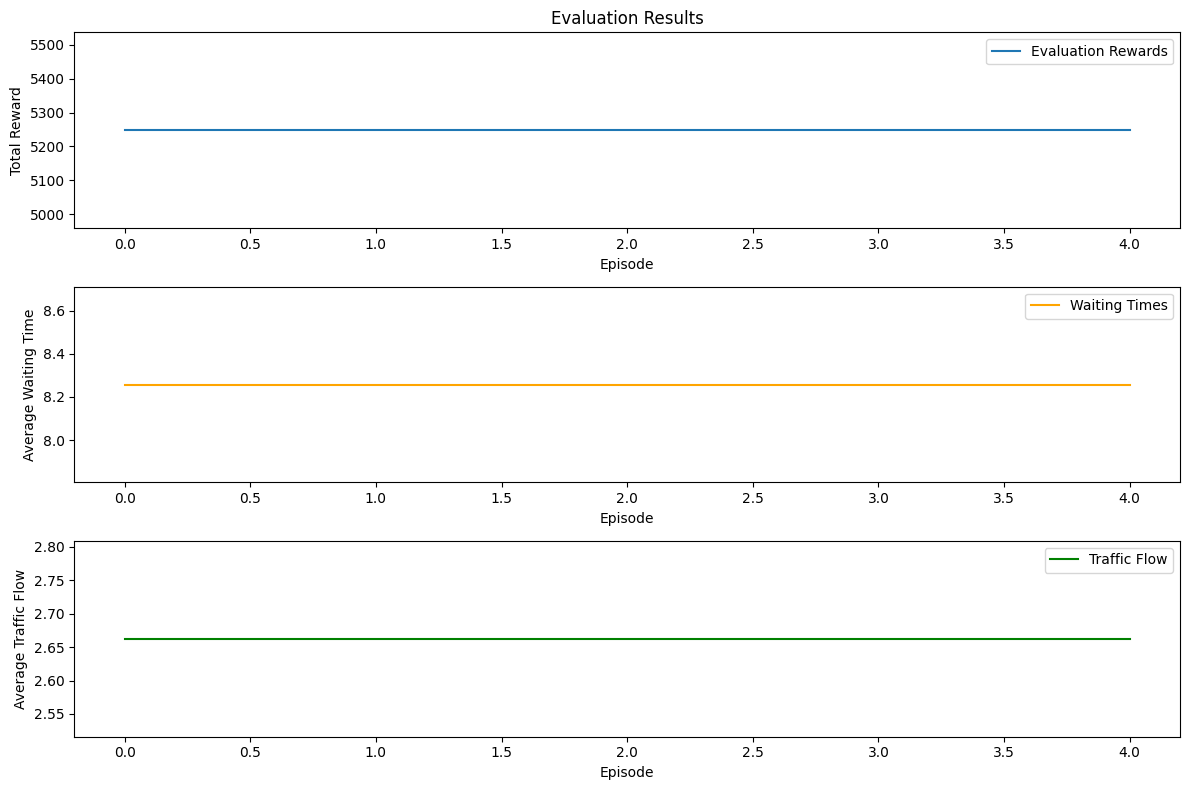

In [5]:
import traci
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

# DQN parameters
ALPHA = 0.005
GAMMA = 0.99
EPSILON = 0.1
MAX_EPISODES = 100
ACTIONS = ["green", "yellow", "red"]
STATE_SIZE = 4 # High density, Ramp queue length, Traffic light state
ACTION_SIZE = len(ACTIONS)
BUFFER_SIZE = 20000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Experience replay buffer
experience_replay = deque(maxlen=BUFFER_SIZE)

# Define the Q-network (Neural Network)
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize the Q-network and optimizer
q_network = QNetwork(STATE_SIZE, ACTION_SIZE)
optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

def get_state():
    """Normalized state representation"""
    highway_density = len(traci.edge.getLastStepVehicleIDs("2to3")) / 15.0
    ramp_queue = len(traci.edge.getLastStepVehicleIDs("intramp")) / 10.0
    waiting_time = traci.edge.getWaitingTime("intramp") / 100.0  # New feature
    light_state = traci.trafficlight.getRedYellowGreenState("node6")
    light_index = {"G": 0, "y": 0.5, "r": 1}.get(light_state, 1)
    return np.array([highway_density, ramp_queue, waiting_time, light_index], dtype=np.float32)




def take_action(action):
    """Apply action to traffic light node6"""
    if action == 0:
        traci.trafficlight.setRedYellowGreenState("node6", "G")
    elif action == 1:
        traci.trafficlight.setRedYellowGreenState("node6", "y")
    elif action == 2:
        traci.trafficlight.setRedYellowGreenState("node6", "r")
def get_action(state):
    """
    Epsilon-greedy action selection
    """
    if random.uniform(0, 1) < EPSILON:
        return random.randint(0, ACTION_SIZE - 1)  # Subtract 1 to get valid index range
    
    state_tensor = torch.from_numpy(state).float().unsqueeze(0)
    with torch.no_grad():
        q_values = q_network(state_tensor)
    return torch.argmax(q_values).item()

def get_reward(state, action):
    """Modified reward function focusing on reducing waiting time"""
    ramp_queue = len(traci.edge.getLastStepVehicleIDs("intramp"))
    highway_density = len(traci.edge.getLastStepVehicleIDs("2to3"))
    waiting_time = traci.edge.getWaitingTime("intramp")
    
    reward = 0
    # Stronger penalties for waiting time and queue
    reward -= waiting_time * 0.2  # Increased penalty
    reward -= ramp_queue * 3      # Increased penalty
    
    # Reward for good actions
    if action == 0 and ramp_queue > 0:  # Green when queue exists
        reward += 25  # Increased reward
    elif action == 2 and highway_density > 10:  # Red when congested
        reward += 15
    elif action == 1:  # Discourage unnecessary yellow
        reward -= 10
        
    return reward


# Store metrics for visualization
total_rewards = []
average_waiting_times = []
traffic_flows = []
def calculate_traffic_flow():
    """Calculate traffic flow on main road and ramp"""
    highway_flow = len(traci.edge.getLastStepVehicleIDs("2to3"))
    ramp_flow = len(traci.edge.getLastStepVehicleIDs("intramp"))
    return highway_flow + ramp_flow

def calculate_average_waiting_time():
    """Modified waiting time calculation"""
    waiting_time = traci.edge.getWaitingTime("intramp")
    num_vehicles = max(len(traci.edge.getLastStepVehicleIDs("intramp")), 1)
    return waiting_time / num_vehicles
def evaluate_policy(num_episodes=5):
    # Load saved model
    model_save_path = "D:/3CS/RL/rl for ramp metering/models/dqn_weights.pth"
    eval_network = QNetwork(STATE_SIZE, ACTION_SIZE)
    checkpoint = torch.load(model_save_path)
    eval_network.load_state_dict(checkpoint['model_state_dict'])
    eval_network.eval()  # Set to evaluation mode
    
    eval_rewards = []
    eval_waiting_times = []
    eval_flows = []
    
    for episode in range(num_episodes):
        traci.start(["sumo", "-c", "D:/3CS/RL/rl for ramp metering/sumo/mynet.sumocfg"])
        state = get_state()
        done = False
        episode_reward = 0
        waiting_times = []
        flows = []
        
        while not done:
            # Get action using trained policy (no exploration)
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            with torch.no_grad():
                q_values = eval_network(state_tensor)
            action = torch.argmax(q_values).item()
            
            # Take action
            take_action(action)
            traci.simulationStep()
            
            # Get next state and reward
            next_state = get_state()
            reward = get_reward(state, action)
            episode_reward += reward
            
            # Track metrics
            waiting_times.append(calculate_average_waiting_time())
            flows.append(calculate_traffic_flow())
            
            state = next_state
            if traci.simulation.getMinExpectedNumber() == 0:
                done = True
        
        eval_rewards.append(episode_reward)
        eval_waiting_times.append(np.mean(waiting_times))
        eval_flows.append(np.mean(flows))
        
        print(f"Evaluation Episode {episode + 1}/{num_episodes}, "
              f"Total Reward: {episode_reward:.2f}, "
              f"Avg Waiting Time: {np.mean(waiting_times):.2f}, "
              f"Avg Traffic Flow: {np.mean(flows):.2f}")
        
        traci.close()
    
    return eval_rewards, eval_waiting_times, eval_flows

# Run evaluation
eval_rewards, eval_waiting_times, eval_flows = evaluate_policy()

# Plot evaluation results
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(eval_rewards, label="Evaluation Rewards")
plt.title("Evaluation Results")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(eval_waiting_times, color='orange', label="Waiting Times")
plt.xlabel("Episode")
plt.ylabel("Average Waiting Time")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(eval_flows, color='green', label="Traffic Flow")
plt.xlabel("Episode")
plt.ylabel("Average Traffic Flow")
plt.legend()

plt.tight_layout()
plt.show()

**Without Traffic light**

Evaluation Episode 1/5, Total Reward: 3723.60, Avg Waiting Time: 5.54, Avg Traffic Flow: 2.62
Evaluation Episode 2/5, Total Reward: 3723.60, Avg Waiting Time: 5.54, Avg Traffic Flow: 2.62
Evaluation Episode 3/5, Total Reward: 3723.60, Avg Waiting Time: 5.54, Avg Traffic Flow: 2.62
Evaluation Episode 4/5, Total Reward: 3723.60, Avg Waiting Time: 5.54, Avg Traffic Flow: 2.62
Evaluation Episode 5/5, Total Reward: 3723.60, Avg Waiting Time: 5.54, Avg Traffic Flow: 2.62


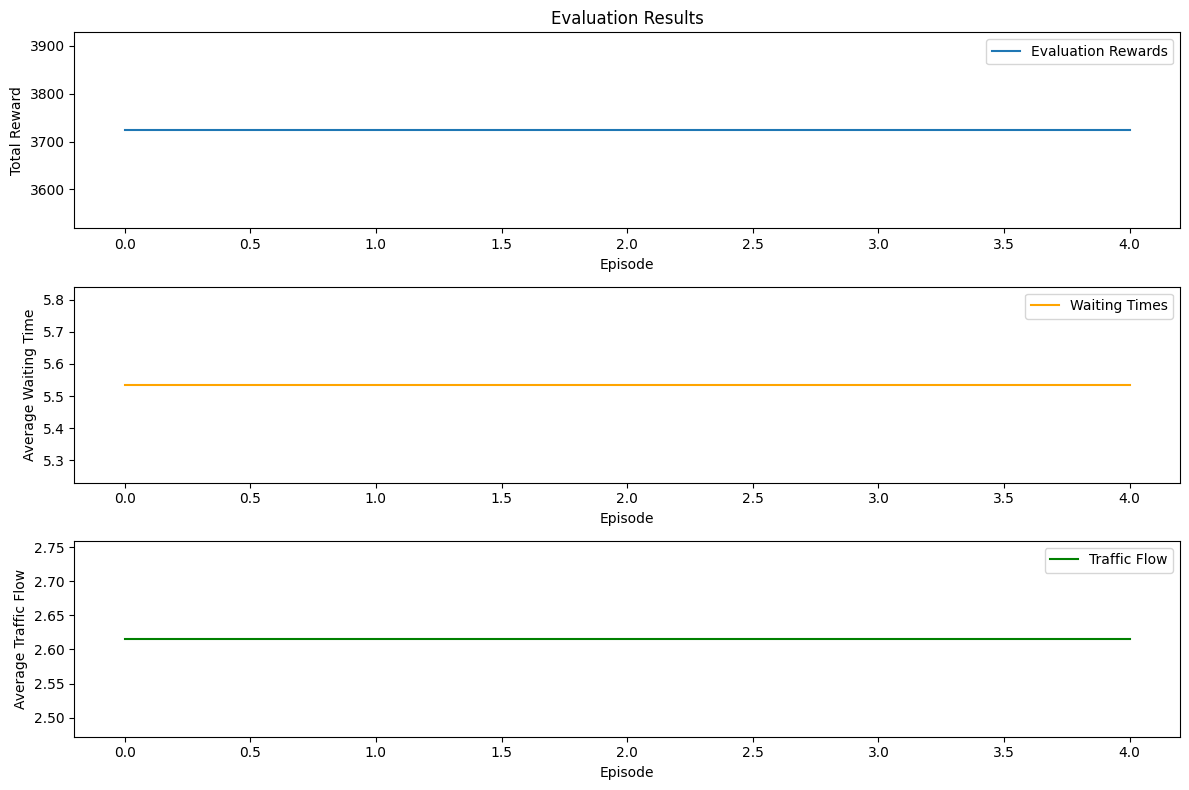

In [5]:
import traci
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

# DQN parameters
ALPHA = 0.005
GAMMA = 0.99
EPSILON = 0.1
MAX_EPISODES = 100
STATE_SIZE = 3  # highway_density, ramp_queue, waiting_time
ACTION_SIZE = 2  # allow/block
BUFFER_SIZE = 20000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Experience replay buffer
experience_replay = deque(maxlen=BUFFER_SIZE)

# Define the Q-network (Neural Network)
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize the Q-network and optimizer
q_network = QNetwork(STATE_SIZE, ACTION_SIZE)
optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

def get_state():
    """Normalized state representation without traffic light"""
    highway_density = len(traci.edge.getLastStepVehicleIDs("2to3")) / 15.0
    ramp_queue = len(traci.edge.getLastStepVehicleIDs("intramp")) / 10.0
    waiting_time = traci.edge.getWaitingTime("intramp") / 100.0
    return np.array([highway_density, ramp_queue, waiting_time], dtype=np.float32)

def take_action(action):
    """Ramp metering action"""
    ramp_vehicles = traci.edge.getLastStepVehicleIDs("intramp")
    for vehicle in ramp_vehicles:
        if action == 0:  # Allow
            traci.vehicle.setSpeed(vehicle, 13.89)  # 50 km/h
        else:  # Block
            traci.vehicle.setSpeed(vehicle, 0)

def get_action(state):
    """Epsilon-greedy action selection"""
    if random.uniform(0, 1) < EPSILON:
        return random.randint(0, ACTION_SIZE - 1)
    
    state_tensor = torch.from_numpy(state).float().unsqueeze(0)
    with torch.no_grad():
        q_values = q_network(state_tensor)
    return torch.argmax(q_values).item()

def get_reward(state, action):
    """Reward function focusing on reducing waiting time"""
    ramp_queue = len(traci.edge.getLastStepVehicleIDs("intramp"))
    highway_density = len(traci.edge.getLastStepVehicleIDs("2to3"))
    waiting_time = traci.edge.getWaitingTime("intramp")
    
    reward = 0
    # Stronger penalties for waiting time and queue
    reward -= waiting_time * 0.2  # Increased penalty
    reward -= ramp_queue * 3      # Increased penalty
    
    # Reward for good actions
    if action == 0 and ramp_queue > 0:  # Allow when queue exists
        reward += 25  # Increased reward
    elif action == 1 and highway_density > 10:  # Block when congested
        reward += 15
        
    return reward

# Store metrics for visualization
total_rewards = []
average_waiting_times = []
traffic_flows = []

def calculate_traffic_flow():
    """Calculate traffic flow on main road and ramp"""
    highway_flow = len(traci.edge.getLastStepVehicleIDs("2to3"))
    ramp_flow = len(traci.edge.getLastStepVehicleIDs("intramp"))
    return highway_flow + ramp_flow

def calculate_average_waiting_time():
    """Modified waiting time calculation"""
    waiting_time = traci.edge.getWaitingTime("intramp")
    num_vehicles = max(len(traci.edge.getLastStepVehicleIDs("intramp")), 1)
    return waiting_time / num_vehicles
def evaluate_policy(num_episodes=5):
    # Load saved model
    model_save_path = "D:/3CS/RL/rl for ramp metering/models/no_traffic_light_dqn.pth"
    eval_network = QNetwork(STATE_SIZE, ACTION_SIZE)
    checkpoint = torch.load(model_save_path)
    eval_network.load_state_dict(checkpoint['model_state_dict'])
    eval_network.eval()
    
    eval_rewards = []
    eval_waiting_times = []
    eval_flows = []
    
    for episode in range(num_episodes):
        traci.start(["sumo", "-c", "D:/3CS/RL/rl for ramp metering/sumo/mynet.sumocfg"])
        state = get_state()
        done = False
        episode_reward = 0
        waiting_times = []
        flows = []
        
        while not done:
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            with torch.no_grad():
                q_values = eval_network(state_tensor)
            action = torch.argmax(q_values).item()
            
            take_action(action)
            traci.simulationStep()
            
            next_state = get_state()
            reward = get_reward(state, action)
            episode_reward += reward
            
            waiting_times.append(calculate_average_waiting_time())
            flows.append(calculate_traffic_flow())
            
            state = next_state
            if traci.simulation.getMinExpectedNumber() == 0:
                done = True
        
        eval_rewards.append(episode_reward)
        eval_waiting_times.append(np.mean(waiting_times))
        eval_flows.append(np.mean(flows))
        
        print(f"Evaluation Episode {episode + 1}/{num_episodes}, "
              f"Total Reward: {episode_reward:.2f}, "
              f"Avg Waiting Time: {np.mean(waiting_times):.2f}, "
              f"Avg Traffic Flow: {np.mean(flows):.2f}")
        
        traci.close()
    
    return eval_rewards, eval_waiting_times, eval_flows

# Run evaluation
eval_rewards, eval_waiting_times, eval_flows = evaluate_policy()

# Plot evaluation results
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(eval_rewards, label="Evaluation Rewards")
plt.title("Evaluation Results")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(eval_waiting_times, color='orange', label="Waiting Times")
plt.xlabel("Episode")
plt.ylabel("Average Waiting Time")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(eval_flows, color='green', label="Traffic Flow")
plt.xlabel("Episode")
plt.ylabel("Average Traffic Flow")
plt.legend()

plt.tight_layout()
plt.show()